# **Question 1**

## **Question 1 (a)**

In [1]:
import sys
import json
import re
import argparse
import csv
from bs4 import BeautifulSoup
import time
import requests
from requests.adapters import HTTPAdapter, Retry

utility functions to scrape recipes

In [2]:
recipe_url_regex = r"https://www\.allrecipes\.com/recipe/\d+/.+"
recipes_url_regex = r"https:\/\/www\.allrecipes\.com\/recipes\/\d+\/.+\/"

class ProgressFileError(Exception):
    pass


def get_proxies(file_path):
    with open(file_path, "r") as f:
        proxies = f.read().split("\n")
    return proxies


def rotate_proxy(proxy_counter, proxies):
    proxy_counter += 1
    proxy_counter %= len(proxies)
    return proxy_counter


In [3]:
def parse_category_urls(s, proxy_counter, proxies, max_categories, use_proxy=False):
    global recipes_url_regex
    recipes_categories = []
    categories_req = None
    try:
        categories_req = s.get("https://www.allrecipes.com/recipes-a-z-6735880")
    except Exception:
        if use_proxy:
            proxy_counter = rotate_proxy(proxy_counter, proxies)

    if categories_req and categories_req.status_code == 200:
        soup = BeautifulSoup(categories_req.text, "html.parser")

        links = soup.find_all("a", class_="mntl-link-list__link")
        for link in links:
            if max_categories == len(recipes_categories):
                break
            href = link.get("href")
            if href and re.match(recipes_url_regex, href):
                recipes_categories.append(href)
    else:
        print("Failed to retrieve categories.")

    return recipes_categories, proxy_counter

def get_category(s, category_url, proxy_counter, proxies, use_proxy=False):
    category_req = None
    try:
        category_req = s.get(category_url)
    except Exception as e:
        if use_proxy:
            proxy_counter = rotate_proxy(proxy_counter, proxies)
    return category_req, proxy_counter

def get_category_recipes_urls(category):
    global recipe_url_regex
    category_urls = []
    recipes_soup = BeautifulSoup(category.text, "html.parser")
    recipes_soup = recipes_soup.find_all("a", {"class": "card"})
    for k, recipe_link in enumerate(recipes_soup):
        if re.match(recipe_url_regex, recipe_link["href"]):
            category_urls.append(recipe_link["href"])
    return category_urls

def get_recipe(s, recipe_url, proxy_counter, proxies, use_proxy=False):
    recipe_req = None
    data = None
    try:
        recipe_req = s.get(recipe_url)
    except Exception:
        if use_proxy:
            proxy_counter = rotate_proxy(proxy_counter, proxies)
    try:
        if recipe_req and recipe_req.status_code == 200:
            recipe_soup = BeautifulSoup(recipe_req.text, "html.parser")
            recipe_data = recipe_soup.find(
                "script", {"class": "allrecipes-schema"})

            headline = json.loads(recipe_data.text)[0].get("headline", "No headline found")
            recipe_instructions = json.loads(recipe_data.text)[0].get("recipeInstructions", [])
            recipe_ingredients = json.loads(recipe_data.text)[0].get("recipeIngredient", [])
            recipe_prep_time = json.loads(recipe_data.text)[0].get("prepTime", "No prep time found")
            with open("recipes.csv", mode="a", newline='', encoding="utf-8") as file:
                writer = csv.writer(file)
                if file.tell() == 0:
                    writer.writerow(["Recipe name", "Recipe URL", "List of ingredient phrases", "List of instructions", "Preparation time"])
                formatted_instructions = " ".join([step['text'] for step in recipe_instructions])
                formatted_ingredients = " ; ".join(recipe_ingredients)
                if (recipe_prep_time[0] == 'P') and (recipe_prep_time[1] == 'T'):
                    recipe_prep_time = recipe_prep_time[2:-1] + " mins"
                writer.writerow([headline, recipe_url,  formatted_ingredients, formatted_instructions,  recipe_prep_time])

    except Exception:
        pass
    return None, proxy_counter


variables to run the main scrape function

In [4]:

max_recipes = 100000
max_categories = 30000
output_file = 'recipes.json'
use_proxy = None
proxy_file = "proxies.txt"

s = requests.Session()
proxy_counter = 0

retries = Retry(total=5,
                backoff_factor=0.1,
                status_forcelist=[500, 502, 503, 504])
s.mount('http://', HTTPAdapter(max_retries=retries))
s.headers = {
    "User-Agent": "Mozilla/5.0 (X11 Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome /"
}
s.timeout = 10

proxies = []
if use_proxy:
    proxies = get_proxies(proxy_file)
    s.proxies = proxies

recipe_categories, proxy_counter = parse_category_urls(s, proxy_counter, proxies, max_categories, use_proxy)
recipes_count = 0

In [5]:
def scrape_recipes(s, recipe_categories, max_categories, max_recipes):
    global proxy_counter, recipes_count, proxies, use_proxy
    for i, category_url in enumerate(recipe_categories):
        if recipes_count >= max_recipes:
            break
        if i == max_categories:
            break

        category, proxy_counter = get_category(s, category_url, proxy_counter, proxies, use_proxy)

        category_urls = get_category_recipes_urls(category)
        for j, recipe_url in enumerate(category_urls):
            if recipes_count >= max_recipes:
                break
            recipes_count += 1
            recipe_data, proxy_counter = get_recipe(
                s, recipe_url, proxy_counter, proxies, use_proxy)

scrape_recipes(s, recipe_categories, max_categories, max_recipes)

**Question 1 (b)**

In [6]:
import pandas as pd
import spacy
import re

nlp = spacy.load("en_core_web_sm")

fluff_words = [
    'or as needed', 'or to', 'taste', 'fresh', 'finely', 'tablespoon', 'teaspoon', 'cup', 'pound', 'ounce',
    'gram', 'liter', 'ml', 'pinch', 'dash', 'clove', 'stick', 'slice', 'chopped', 'minced', 'diced',
    'tablespoons', 'teaspoons', 'cups', 'pounds', 'ounces', 'grams', 'liters', 'cold', 'unsalted',
    'large', 'medium', 'small', 'sliced', 'cubed', 'shredded', 'grated', 'crushed', 'whole', 'baked',
    'roasted', 'steamed', 'boiled', 'cooked', 'raw', 'sweetened', 'unsweetened', 'browned', 'finely',
    'coarsely', 'medium-sized', 'garnished', 'with', 'thinly', 'thickly', 'and', 'to', '(', ')', 'melted',
    'inch', 'thick', 'halved', 'divided', 'beaten', 'or', 'cold'
]


ModuleNotFoundError: No module named 'spacy'

In [ ]:
def clean_ingredient(ingredient):
    ingredient = re.sub(r'\(.*?\)', '', ingredient)
    for fluff in fluff_words:
        ingredient = re.sub(r'\b' + re.escape(fluff) + r'\b', '', ingredient)
    ingredient = re.sub(r'\b\d+(\.\d+)?\b', '', ingredient)
    ingredient = re.sub(r'\s+', ' ', ingredient).strip()
    ingredient = re.sub(r',\s*$', '', ingredient)
    return ingredient


def extract_ingredients_ner(ingredient_text):
    ingredient_text = clean_ingredient(ingredient_text)
    doc = nlp(ingredient_text)
    ingredients = []

    noun_phrases = [chunk.text for chunk in doc.noun_chunks]
    if noun_phrases:
      ingredients.extend(noun_phrases)
    else:
      ingredients.append(ingredient_text)

    cleaned_ingredients = [clean_ingredient(ingredient) for ingredient in ingredients]
    return cleaned_ingredients

df = pd.read_csv("recipes.csv")

df['Recipe ID'] = ['Recipe ' + str(i+1) for i in range(len(df))]

ingredient_data = []
for index, row in df.iterrows():
    recipe_id = row['Recipe ID']
    ingredient_phrases = row['List of ingredient phrases'].split(' ; ')
    for phrase in ingredient_phrases:
        ingredients = extract_ingredients_ner(phrase)

        for ingredient in ingredients:
            if ingredient:
                ingredient_data.append({
                    'Recipe ID': recipe_id,
                    'Ingredient': ingredient
                })

ingredient_df = pd.DataFrame(ingredient_data)

ingredient_df = ingredient_df.drop_duplicates()

ingredient_df.to_csv("non_duplicate_ingredients.csv", index=False)

print("Recipe IDs assigned, non-duplicate ingredients extracted, cleaned of numbers and fluff words, and saved to non_duplicate_ingredients.csv")


**Question 1 (c)**

In [ ]:
import pandas as pd
import random

df = pd.read_csv("non_duplicate_ingredients.csv")

if len(df['Recipe ID'].unique()) < 100:
    raise ValueError("Not enough unique recipes to choose 100.")

random_recipe_ids = random.sample(df['Recipe ID'].unique().tolist(), 100)

filtered_df = df[df['Recipe ID'].isin(random_recipe_ids)]

output_lines = []

for recipe_id in random_recipe_ids:

    ingredient_phrases = filtered_df[filtered_df['Recipe ID'] == recipe_id]['Ingredient']
    for ingredient in ingredient_phrases:
        split_ingredients = [i.strip() for i in ingredient.split(',') if i.strip()]
        for split_ingredient in split_ingredients:
            output_lines.append(f"{recipe_id}—{split_ingredient}")

with open("recipes_ingredients.txt", "w") as file:
    file.write("\n".join(output_lines))

print("Recipe IDs and ingredient information saved to recipes_ingredients.txt")


# **Question 2**

**Question 2 (a)**

In [ ]:
import pandas as pd

# Load the CSV file
file_path = 'non_duplicate_ingredients.csv'  # Replace with the path to your CSV file
df = pd.read_csv(file_path)

# Clean the ingredient column (lowercase, strip whitespace)
df['Ingredient'] = df['Ingredient'].str.lower().str.strip()

# Count the unique ingredients and their frequencies
ingredient_counts = df['Ingredient'].value_counts()

# Save the result to a new CSV file
output_file_path = 'unique_ingredient_frequencies.csv'
ingredient_counts.to_csv(output_file_path, header=['Frequency'])

# Print the result
print(f'Unique ingredients and their frequencies saved to {output_file_path}')


Unique ingredients and their frequencies saved to unique_ingredient_frequencies.csv


**Question 2 (b)**

Recipe size distribution plot with probabilities saved to recipe_size_distribution_probability.png


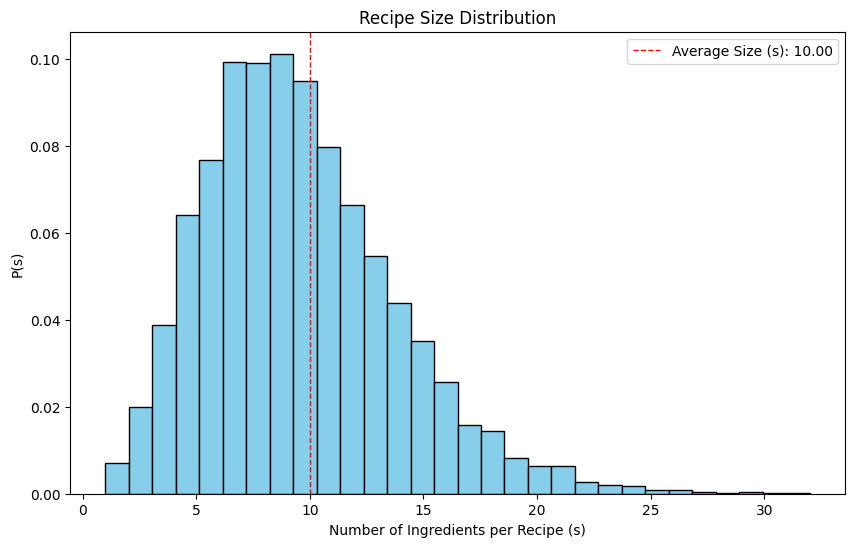

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'non_duplicate_ingredients.csv'  # Replace with the path to your CSV file
df = pd.read_csv(file_path)

# Clean the ingredient column (lowercase, strip whitespace)
df['Ingredient'] = df['Ingredient'].str.lower().str.strip()

# Count the number of ingredients per recipe
recipe_sizes = df.groupby('Recipe ID').size()

# Compute the average recipe size
average_size = round(recipe_sizes.mean())

# Plot the recipe size distribution normalized to probabilities
plt.figure(figsize=(10, 6))
plt.hist(recipe_sizes, bins=30, density=True, color='skyblue', edgecolor='black')
plt.axvline(average_size, color='red', linestyle='dashed', linewidth=1, label=f'Average Size (s): {average_size:.2f}')
plt.title('Recipe Size Distribution')
plt.xlabel('Number of Ingredients per Recipe (s)')
plt.ylabel('P(s)')
plt.legend()

# Save the plot to a file
output_plot_path = 'recipe_size_distribution_probability.png'
plt.savefig(output_plot_path)

# Print the result
print(f'Recipe size distribution plot with probabilities saved to {output_plot_path}')


Cumulative distribution plot saved to cumulative_recipe_size_distribution.png


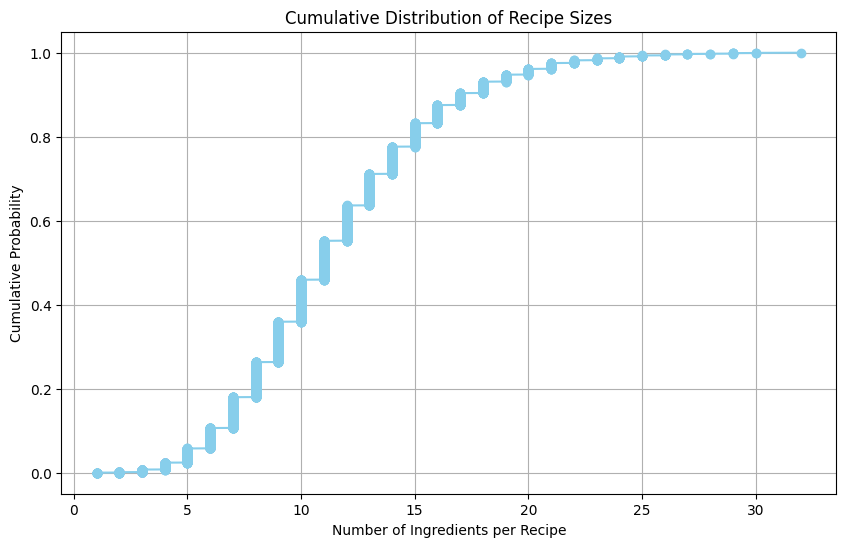

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'non_duplicate_ingredients.csv'  # Replace with the path to your CSV file
df = pd.read_csv(file_path)

# Clean the ingredient column (lowercase, strip whitespace)
df['Ingredient'] = df['Ingredient'].str.lower().str.strip()

# Count the number of ingredients per recipe
recipe_sizes = df.groupby('Recipe ID').size()

# Compute the cumulative distribution of recipe sizes
recipe_sizes_sorted = recipe_sizes.sort_values()
cumulative = recipe_sizes_sorted.cumsum() / recipe_sizes_sorted.sum()

# Plot the cumulative distribution of recipe sizes
plt.figure(figsize=(10, 6))
plt.plot(recipe_sizes_sorted, cumulative, marker='o', linestyle='-', color='skyblue')
plt.title('Cumulative Distribution of Recipe Sizes')
plt.xlabel('Number of Ingredients per Recipe')
plt.ylabel('Cumulative Probability')
plt.grid(True)

# Save the plot to a file
output_plot_path = 'cumulative_recipe_size_distribution.png'
plt.savefig(output_plot_path)

# Print the result
print(f'Cumulative distribution plot saved to {output_plot_path}')


Ques 3 ) Frequency and Rank distribution of Recipe Ingredients

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df_ingredients = pd.read_csv('non_duplicate_ingredients.csv')
ingredient_counts = df_ingredients['Ingredient'].value_counts()

ranked_ingredients = ingredient_counts.reset_index()
ranked_ingredients.columns = ['Ingredient', 'Frequency']
ranked_ingredients['Rank'] = ranked_ingredients['Frequency'].rank(method='min', ascending=False)

ranked_ingredients['Normalized Frequency'] = ranked_ingredients['Frequency'] / ranked_ingredients['Frequency'].max()


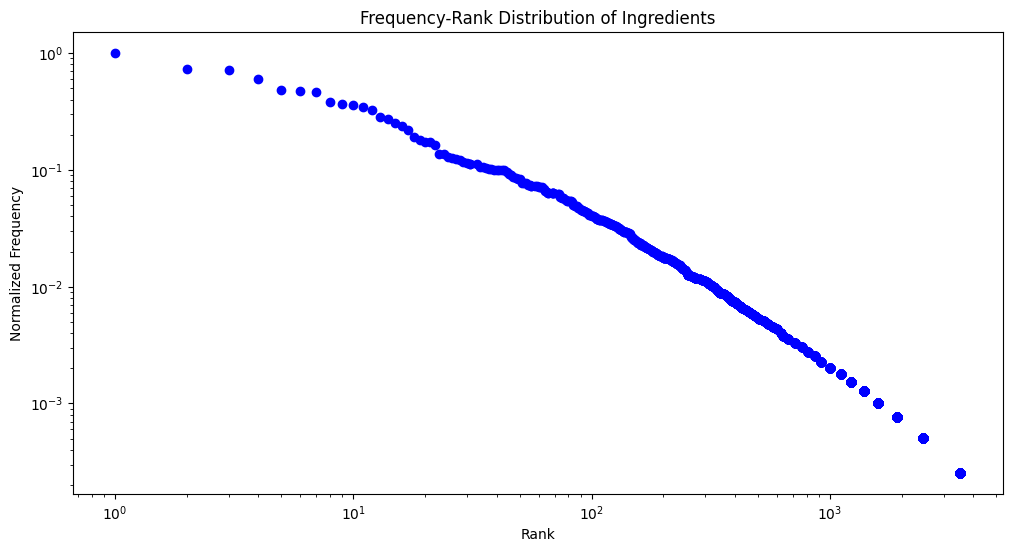

Frequency-rank distribution plot saved as 'frequency_rank_distribution.svg' and 'frequency_rank_distribution.png'.


In [ ]:

plt.figure(figsize=(12, 6))

plt.loglog(ranked_ingredients['Rank'], ranked_ingredients['Normalized Frequency'], marker='o', linestyle='none', color='blue')
plt.xlabel('Rank')
plt.ylabel('Normalized Frequency')
plt.title('Frequency-Rank Distribution of Ingredients')

plt.savefig('Q3_frequency_rank_distribution.png')
plt.savefig('Q3_frequency_rank_distribution.svg')

plt.show()

print("Frequency-rank distribution plot saved as 'frequency_rank_distribution.svg' and 'frequency_rank_distribution.png'.")